## **CNN 이미지 1080*10 사이즈 10 개 생성한 코드 구조 변경**

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

# --------------------
# 기본 변수 설정
# --------------------
INPUT       = 10    # CSI 데이터의 가로
INPUT2      = 1080  # CSI 데이터의 세로
EXPERIMENT  = 10    # 각 위치당 사용되는 이미지 수
NODE1       = 100   # 첫 번째 FC 노드 수
NODE2       = 100   # 두 번째 FC 노드 수
OUTPUT      = 2     # 최종 출력 차원 (x, y 좌표)
TRAIN       = 114   # 학습 데이터 위치 수
TEST        = 27    # 테스트 데이터 위치 수
training_epochs = 250
learning_rate   = 1e-5

# --------------------
# 좌표 데이터 (Train/Test)
# --------------------
# Train 데이터 X 좌표
y1 = [0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
      0, 255.0, 510.0, 765.0, 1020.0, 1275.0, 1530.0, 1785.0, 2040.0, 2295.0, 
      0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0,
      892.5, 1147.5, 1275.0, 1530.0,
      892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
      765.0, 892.5, 1147.5, 1275.0, 1530.0, 1657.5,
      637.5, 892.5, 1657.5, 
      510, 637.5, 1657.5, 1785.0,
      382.5, 637.5, 1657.5, 1912.5, 2040.0,
      382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0,
      382.5, 637.5, 1657.5, 1912.5,
      382.5, 510, 637.5, 1785, 1912.5, 2040.0,
      382.5, 637.5, 892.5, 1147.5, 1402.5, 1657.5, 1912.5,
      382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0]

# Train 데이터 Y 좌표
y2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 
      360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360,
      540, 540, 540, 540,
      720, 720, 720, 720, 720, 720,
      900, 900, 900, 900, 900, 900,
      1080, 1080, 1080,
      1260, 1260, 1260, 1260,
      1440, 1440, 1440, 1440, 1440,
      1620, 1620, 1620, 1620, 1620, 1620, 1620,
      1800, 1800, 1800, 1800,
      1980, 1980, 1980, 1980, 1980, 1980,
      2160, 2160, 2160, 2160, 2160, 2160, 2160,
      2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340,]

# Test 데이터 X 좌표
y3 = [127.5, 382.5, 637.5, 892.5, 1147.5, 1402.5, 1657.5, 1912.5, 2167.5,
      1020, 1402.5,
      1020, 1402.5,
      765, 1785,
      510, 1785,
      510, 1785, 2040,
      510, 765, 1020, 1275, 1530, 1785, 2040 ]

# Test 데이터 Y 좌표
y4 = [180, 180, 180, 180, 180, 180, 180, 180, 180,
      540, 540, 
      900, 900,
      1080, 1080,
      1440, 1440,
      1800, 1800, 1800,
      2160, 2160, 2160, 2160, 2160, 2160, 2160]

# 최대값 (정규화 기준)
max_x = 2295.0
max_y = 2340.0

# 좌표 정규화
y1 = [val / max_x for val in y1]
y2 = [val / max_y for val in y2]
y3 = [val / max_x for val in y3]
y4 = [val / max_y for val in y4]

# --------------------
# 데이터 로드 함수
# --------------------
def get_input(filename, sample, experiment, numdata):
    """
    파일을 읽어 CSI 데이터(이미지)를 numpy 배열로 구성.
    shape: (sample, experiment, INPUT2, numdata)

    sample: 위치(Train=114, Test=27)
    experiment: 한 위치당 이미지 개수(=EXPERIMENT)
    numdata: 가로(=INPUT)
    """
    data = np.zeros((sample, experiment, INPUT2, numdata), dtype=np.float32)
    with open(filename, 'r') as f:
        diag_temp = f.read().split()

    idx = 0
    for i in range(sample):
        for p in range(experiment):
            for l in range(numdata):
                for m in range(INPUT2):
                    data[i, p, m, l] = float(diag_temp[idx])
                    idx += 1
    return data

# --------------------
# CNN Model 정의
# --------------------
class CNNModel(nn.Module):
    """
    3개의 합성곱 + 풀링 계층(conv1, conv2, conv3)
    Flatten 후 Fully Connected Layer(fc1, fc2, fc3)을 통해
    최종 (x, y) 좌표 예측
    """
    def __init__(self):
        super(CNNModel, self).__init__()
        # conv1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(8, 2), stride=(4, 2))
        )

        # conv2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 2), stride=(2, 2))
        )

        # conv3
        # padding=(1,1)로 조정해 Flatten 차원(1064) 확보
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        )

        # Fully Connected
        self.fc1 = nn.Linear(in_features=1064, out_features=NODE1)
        self.fc2 = nn.Linear(NODE1, NODE2)
        self.fc3 = nn.Linear(NODE2, OUTPUT)

    def forward(self, x):
        # (1) CNN 계층: 특징 추출
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # (2) Flatten → FC → 출력
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ----------------------------
# 데이터 로드
# ----------------------------
train_data = get_input("result_250227_train.txt", TRAIN, EXPERIMENT, INPUT)
test_data  = get_input("result_250227_test.txt",  TEST,  EXPERIMENT, INPUT)

# ----------------------------
# 모델, 손실함수, 옵티마이저 설정
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

mse_criterion = nn.MSELoss()
optimizer     = optim.Adam(model.parameters(), lr=learning_rate)

# --------------------
# 최소 distance_accuracy 모니터링 변수
# --------------------
best_dist_acc = float('inf')
best_epoch    = 0

# --------------------
# 학습 & 테스트 Loop
# --------------------
for epoch in range(training_epochs):
    #=== TRAINING ============================================
    model.train()
    total_train_rmse = 0.0

    for j in range(EXPERIMENT):
        for i in range(TRAIN):
            x_ = train_data[i, j]
            x_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            # 정답 라벨 텐서 (정규화된 좌표)
            label_tensor = torch.tensor([[y1[i], y2[i]]], dtype=torch.float32).to(device)

            # 역전파 준비
            optimizer.zero_grad()

            # 순전파 & MSE → RMSE
            pred = model(x_tensor)
            mse_loss = mse_criterion(pred, label_tensor)
            rmse_loss = torch.sqrt(mse_loss)

            rmse_loss.backward()  # 역전파
            optimizer.step()      # 가중치 업데이트

            total_train_rmse += rmse_loss.item()

    avg_train_rmse = total_train_rmse / (TRAIN * EXPERIMENT)

    #=== TESTING =============================================
    model.eval()
    sum_rmse   = 0.0
    sum_dist_m = 0.0

    with torch.no_grad():
        for l in range(TEST):
            for j2 in range(EXPERIMENT):
                x_ = test_data[l, j2]
                x_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                label_tensor = torch.tensor([[y3[l], y4[l]]], dtype=torch.float32).to(device)

                # 예측 & RMSE 계산
                pred = model(x_tensor)
                mse  = mse_criterion(pred, label_tensor)
                rmse = torch.sqrt(mse)
                sum_rmse += rmse.item()

                # 실제 거리(m) 계산
                px_norm = pred[0, 0].item()
                py_norm = pred[0, 1].item()
                rx_norm = label_tensor[0, 0].item()
                ry_norm = label_tensor[0, 1].item()

                # 정규화 해제 (cm)
                px_cm = px_norm * max_x
                py_cm = py_norm * max_y
                rx_cm = rx_norm * max_x
                ry_cm = ry_norm * max_y

                dist_m  = math.sqrt((px_cm - rx_cm)**2 + (py_cm - ry_cm)**2) / 100.0
                sum_dist_m += dist_m

    avg_test_rmse = sum_rmse / (TEST * EXPERIMENT)
    avg_dist_m    = sum_dist_m / (TEST * EXPERIMENT)

    # 결과 출력
    print(f"[Epoch {epoch+1}/{training_epochs}] "
          f"Train Loss={avg_train_rmse:.4f}, "
          f"Test Loss={avg_test_rmse:.4f}, "
          f"distance_accuracy={avg_dist_m:.3f}m")

    #=== 최소 distance_accuracy 갱신 여부 확인
    if avg_dist_m < best_dist_acc:
        best_dist_acc = avg_dist_m
        best_epoch    = epoch + 1

# --------------------
# 학습 종료 후 결과
# --------------------
print(f"\nMinimum distance_accuracy = {best_dist_acc:.3f}m at epoch {best_epoch}")

# --------------------
# 최종 예측 결과 저장
# --------------------
model.eval()
sum_dist_m2 = 0.0
result1 = np.zeros((TEST, EXPERIMENT), dtype=np.float32)  # 예측 x좌표(정규화)
result2 = np.zeros((TEST, EXPERIMENT), dtype=np.float32)  # 예측 y좌표(정규화)

with torch.no_grad():
    for l in range(TEST):
        for j in range(EXPERIMENT):
            x_ = test_data[l, j]
            x_tensor   = torch.tensor(x_, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            label_tensor = torch.tensor([[y3[l], y4[l]]], dtype=torch.float32).to(device)

            pred = model(x_tensor)
            px_norm = pred[0, 0].item()
            py_norm = pred[0, 1].item()

            # distance_accuracy(m) 계산
            px_cm = px_norm * max_x
            py_cm = py_norm * max_y
            rx_cm = label_tensor[0, 0].item() * max_x
            ry_cm = label_tensor[0, 1].item() * max_y
            dist_cm = math.sqrt((px_cm - rx_cm)**2 + (py_cm - ry_cm)**2)
            sum_dist_m2 += dist_cm / 100.0

            # 예측 결과 저장
            result1[l, j] = px_norm
            result2[l, j] = py_norm

final_acc_m = sum_dist_m2 / (TEST * EXPERIMENT)
print(f"\nFinal distance_accuracy(m): {final_acc_m:.4f}")

filename = "result_cnn_prediction_250411.txt"
with open(filename, "w") as f:
    for i in range(TEST):
        for j in range(EXPERIMENT):
            f.write(f"{result1[i, j]:.6f} {result2[i, j]:.6f}\n")

print("Done! Saved predictions to", filename)

[Epoch 1/250] Train Loss=0.3315, Test Loss=0.2879, distance_accuracy=9.466m
[Epoch 2/250] Train Loss=0.3015, Test Loss=0.2858, distance_accuracy=9.396m
[Epoch 3/250] Train Loss=0.2980, Test Loss=0.2828, distance_accuracy=9.296m
[Epoch 4/250] Train Loss=0.2930, Test Loss=0.2781, distance_accuracy=9.143m
[Epoch 5/250] Train Loss=0.2853, Test Loss=0.2699, distance_accuracy=8.872m
[Epoch 6/250] Train Loss=0.2707, Test Loss=0.2543, distance_accuracy=8.359m
[Epoch 7/250] Train Loss=0.2412, Test Loss=0.2241, distance_accuracy=7.363m
[Epoch 8/250] Train Loss=0.1952, Test Loss=0.1805, distance_accuracy=5.924m
[Epoch 9/250] Train Loss=0.1581, Test Loss=0.1592, distance_accuracy=5.223m
[Epoch 10/250] Train Loss=0.1385, Test Loss=0.1498, distance_accuracy=4.915m
[Epoch 11/250] Train Loss=0.1272, Test Loss=0.1452, distance_accuracy=4.766m
[Epoch 12/250] Train Loss=0.1205, Test Loss=0.1426, distance_accuracy=4.684m
[Epoch 13/250] Train Loss=0.1157, Test Loss=0.1410, distance_accuracy=4.630m
[Epoch 1

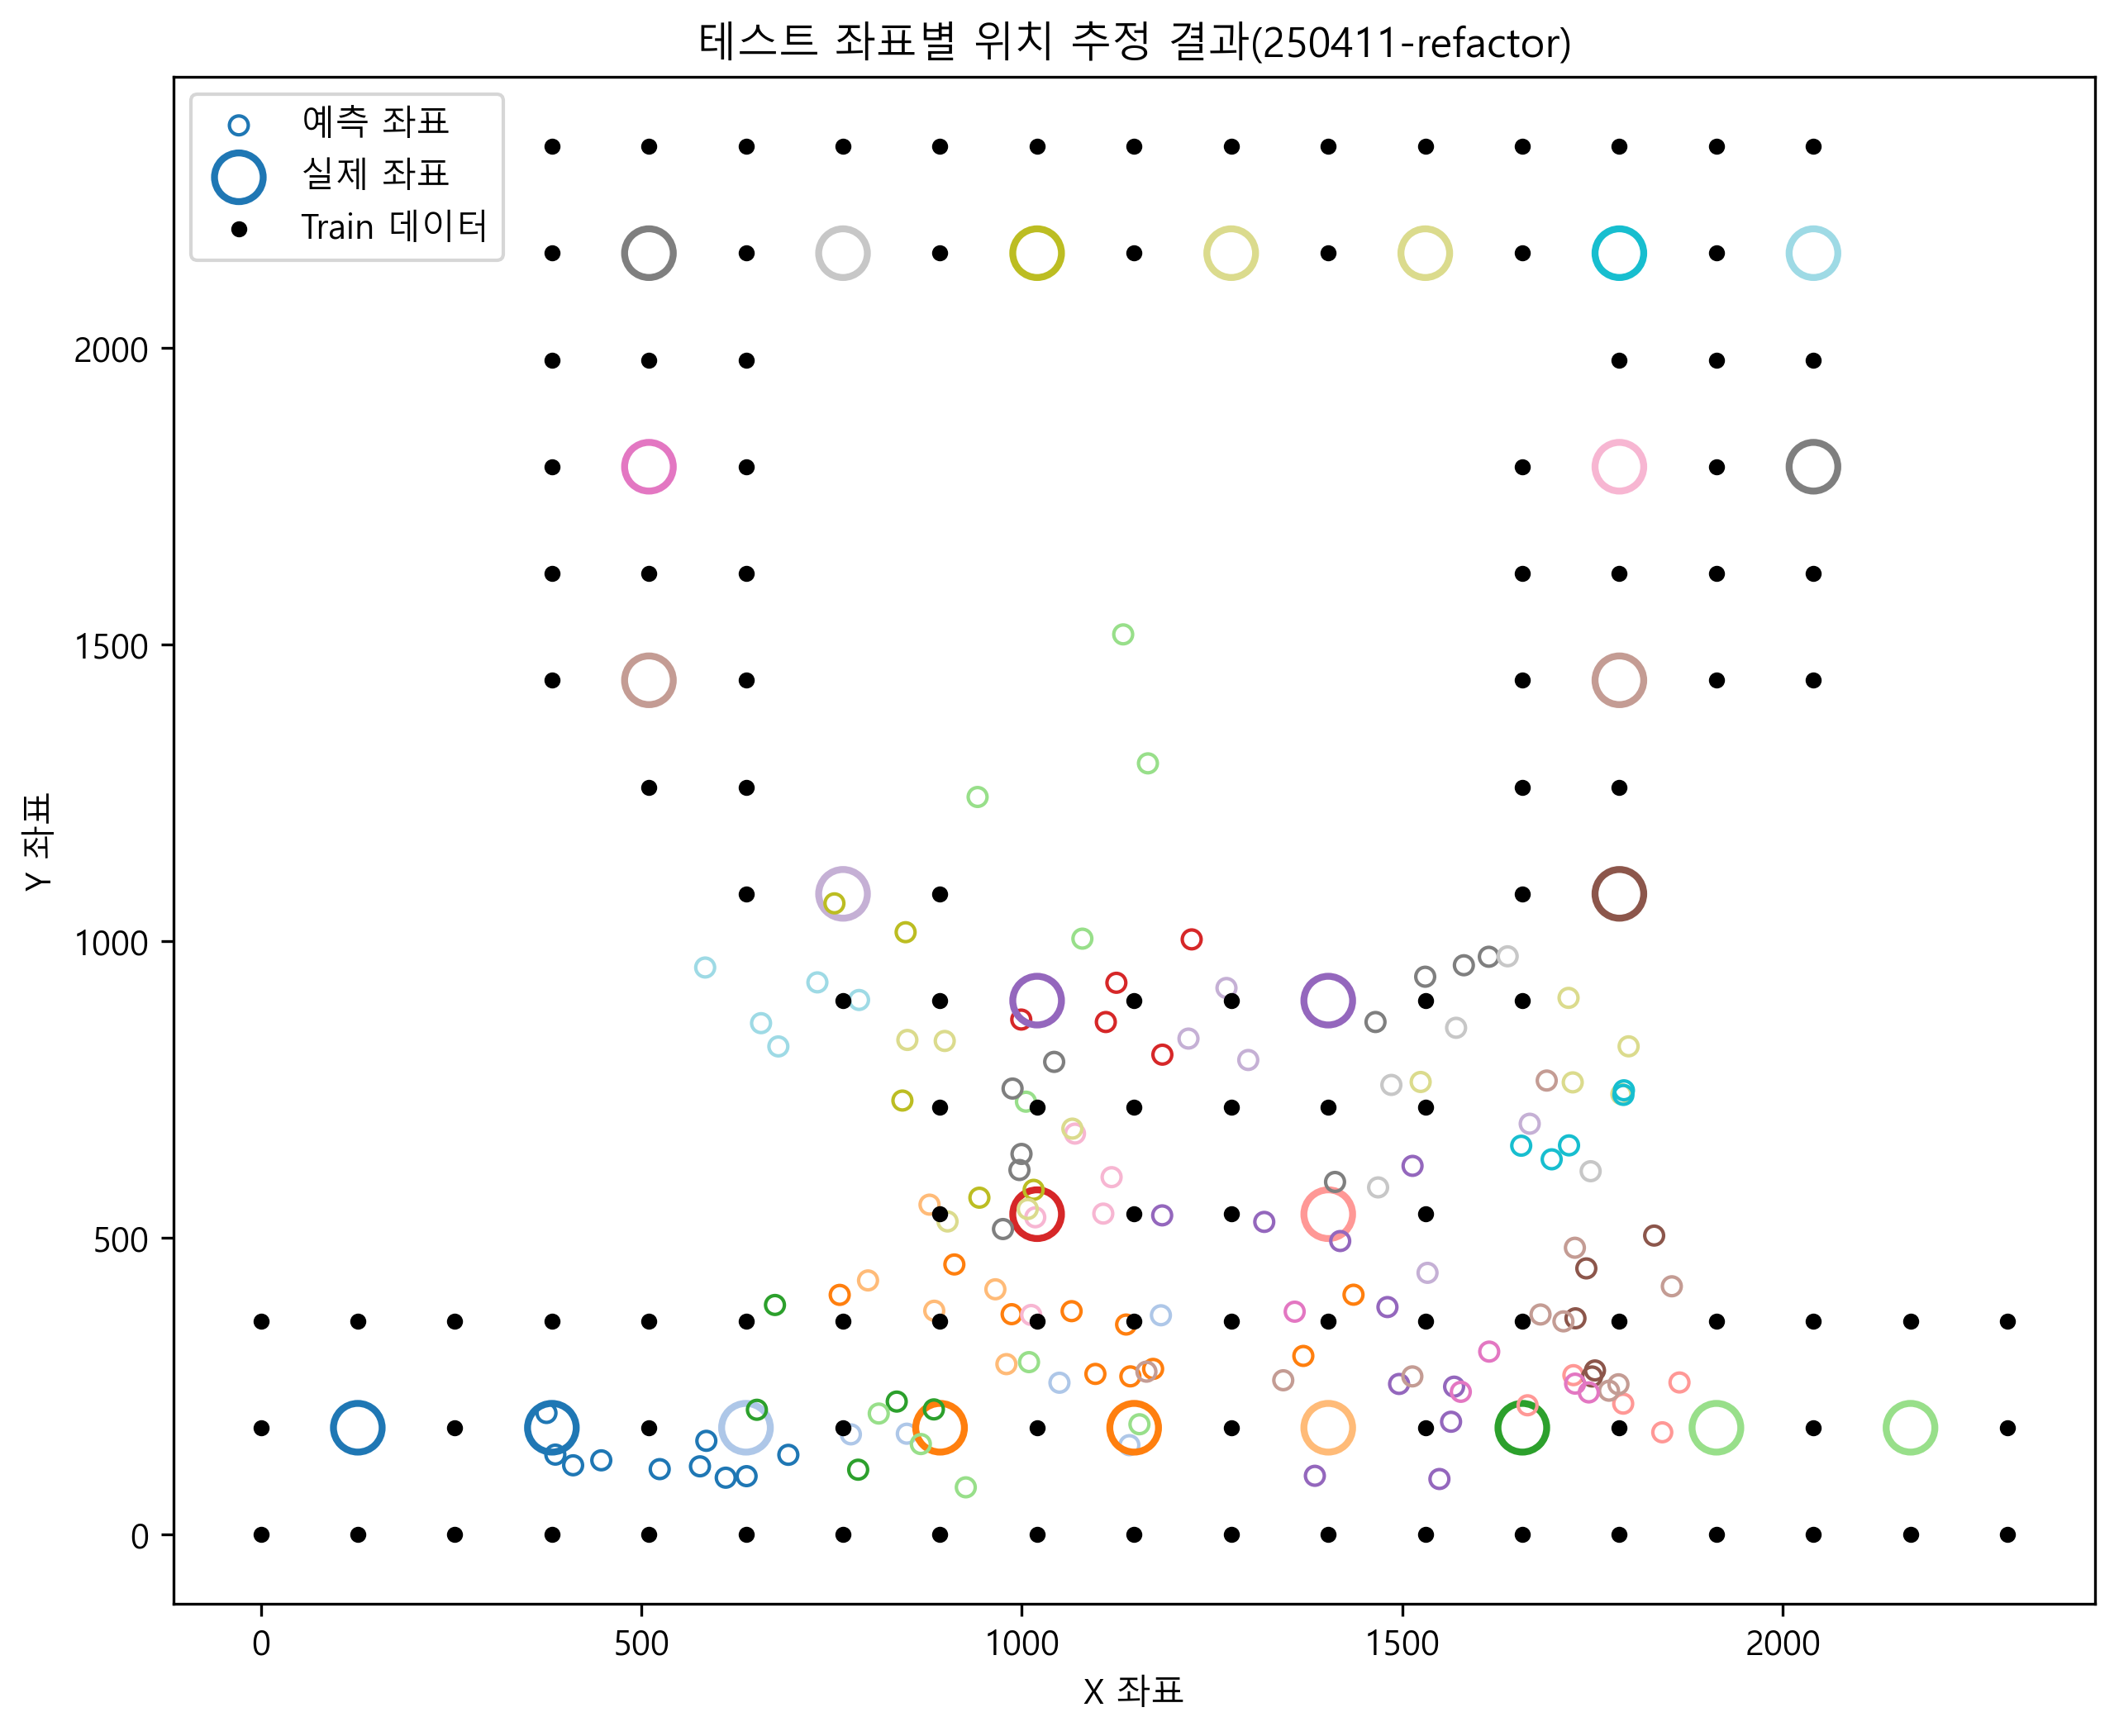

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------------------------------------------
# 1) 예측 결과 불러오기
#    (각 테스트 포인트당 5개의 예측값)
# ------------------------------------------------------------------
result = np.loadtxt('result_cnn_prediction_250411.txt')  # shape: (numTest*EXPERIMENT, 2)
EXPERIMENT = 5    # 각 테스트 지점당 예측 횟수
numTest = 27      # 테스트 지점(좌표) 개수

# 좌표 스케일 복원
result[:, 0] *= 2295
result[:, 1] *= 2340

# ------------------------------------------------------------------
# 2) Train 데이터 좌표, Test 데이터 좌표
# ------------------------------------------------------------------
y1 = np.array([0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 
               1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
               0, 255.0, 510.0, 765.0, 1020.0, 1275.0, 1530.0, 1785.0, 2040.0, 2295.0, 
               0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 
               1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
               892.5, 1147.5, 1275.0, 1530.0, 
               892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 
               765.0, 892.5, 1147.5, 1275.0, 1530.0, 1657.5, 
               637.5, 892.5, 1657.5, 
               510, 637.5, 1657.5, 1785.0, 
               382.5, 637.5, 1657.5, 1912.5, 2040.0, 
               382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0, 
               382.5, 637.5, 1657.5, 1912.5, 
               382.5, 510, 637.5, 1785, 1912.5, 2040.0, 
               382.5, 637.5, 892.5, 1147.5, 1402.5, 1657.5, 1912.5, 
               382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0])
               
y2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
               180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 
               360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 
               540, 540, 540, 540, 
               720, 720, 720, 720, 720, 720, 
               900, 900, 900, 900, 900, 900, 
               1080, 1080, 1080, 
               1260, 1260, 1260, 1260, 
               1440, 1440, 1440, 1440, 1440, 
               1620, 1620, 1620, 1620, 1620, 1620, 1620, 
               1800, 1800, 1800, 1800, 
               1980, 1980, 1980, 1980, 1980, 1980, 
               2160, 2160, 2160, 2160, 2160, 2160, 2160, 
               2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340])

y3 = np.array([127.5, 382.5, 637.5, 892.5, 1147.5, 1402.5, 1657.5, 1912.5, 2167.5, 
               1020, 1402.5, 1020, 1402.5, 765, 1785, 510, 1785, 510, 1785, 2040, 
               510, 765, 1020, 1275, 1530, 1785, 2040])
               
y4 = np.array([180, 180, 180, 180, 180, 180, 180, 180, 180, 
               540, 540, 900, 900, 1080, 1080, 1440, 1440, 1800, 1800, 1800, 
               2160, 2160, 2160, 2160, 2160, 2160, 2160])

# ------------------------------------------------------------------
# 3) 컬러맵 생성 (예: rainbow)
#    각 테스트 지점(i)에 고유 색상
# ------------------------------------------------------------------
colors = [cm.tab20(i / numTest) for i in range(numTest)]

plt.figure(figsize=(10, 8), dpi=300)

# ------------------------------------------------------------------
# 4) 각 테스트 지점별로 실제 좌표 + 예측 좌표
# ------------------------------------------------------------------
for i in range(numTest):
    # i번째 테스트 좌표 범위
    idx_start = i * EXPERIMENT
    idx_end   = (i + 1) * EXPERIMENT

    # i번째 색상
    c = colors[i]

    # --(A) 예측 좌표 5개 (작은 점)--
    plt.scatter(result[idx_start:idx_end, 0],
                result[idx_start:idx_end, 1],
                s=30,
                color=c,
                marker='o',
                facecolors='none',
                edgecolors=c,
                linewidths=1.0,
                label='예측 좌표' if i == 0 else "")

    # --(B) 실제 테스트 좌표 (1개, 큰 점)--
    plt.scatter(y3[i],
                y4[i],
                s=200,
                color=c,
                marker='o',
                facecolors='none',
                edgecolors=c,
                linewidths=2,
                label='실제 좌표' if i == 0 else "")

# ------------------------------------------------------------------
# 5) Train 데이터 표시 (검정색 작은 점)
# ------------------------------------------------------------------
plt.scatter(y1,
            y2,
            s=10,
            color='black',
            marker='o',
            facecolors='black',   # 내부 비움
            edgecolors='black',
            linewidths= 1.5,
            label='Train 데이터')

# ------------------------------------------------------------------
# 6) 그래프 꾸미기
# ------------------------------------------------------------------
plt.title('테스트 좌표별 위치 추정 결과(250411-refactor)')
plt.xlabel('X 좌표')
plt.ylabel('Y 좌표')
plt.legend(loc='best')
plt.show()
